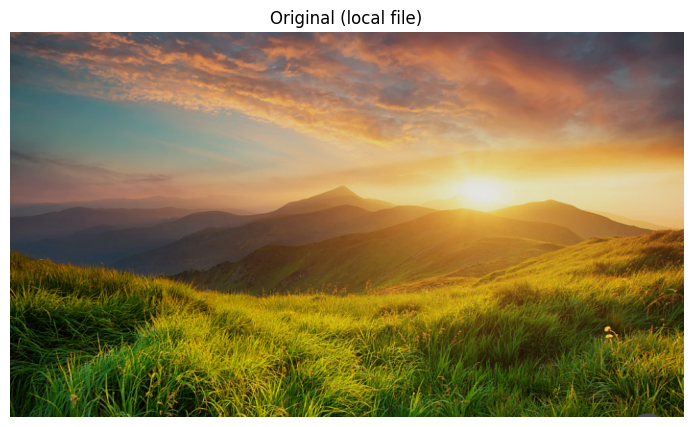

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

path = "image.png"   # <-- your file name here
img = Image.open(path).convert("RGB")
orig_u8 = np.array(img, dtype=np.uint8)

plt.figure(figsize=(10,5))
plt.imshow(orig_u8)
plt.title("Original (local file)")
plt.axis("off")
plt.show()


In [2]:
# ====== GLOBAL SETUP (RUN FIRST) ======
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io


In [3]:
def extract_lsb_region(image, top_left, wm_shape, channel=2):
    """
    Extract LSB bits from a specific region of an image
    """
    r, c = top_left
    h, w = wm_shape
    region = image[r:r+h, c:c+w, channel]
    return region & 1


def compute_ber(original_bits, extracted_bits):
    """
    Compute Bit Error Rate (BER)
    """
    min_h = min(original_bits.shape[0], extracted_bits.shape[0])
    min_w = min(original_bits.shape[1], extracted_bits.shape[1])

    original_bits = original_bits[:min_h, :min_w]
    extracted_bits = extracted_bits[:min_h, :min_w]

    errors = np.sum(original_bits != extracted_bits)
    total_bits = original_bits.size
    return errors / total_bits


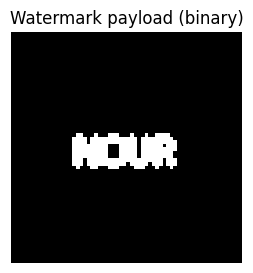

In [4]:
# Cell A — Make a tiny binary watermark payload (64×64)
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

def make_binary_logo(text="NOUR", size=64):
    im = Image.new("L", (size, size), color=0)
    draw = ImageDraw.Draw(im)
    font = ImageFont.load_default()

    # center text
    tw, th = draw.textbbox((0, 0), text, font=font)[2:]
    x = (size - tw) // 2
    y = (size - th) // 2

    # draw + thicken a bit
    draw.text((x, y), text, fill=255, font=font)
    for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
        draw.text((x+dx, y+dy), text, fill=255, font=font)

    arr = np.array(im, dtype=np.uint8)
    return (arr > 128).astype(np.uint8)

wm_bits = make_binary_logo("NOUR", 64)

plt.figure(figsize=(3,3))
plt.imshow(wm_bits, cmap="gray")
plt.title("Watermark payload (binary)")
plt.axis("off")
plt.show()


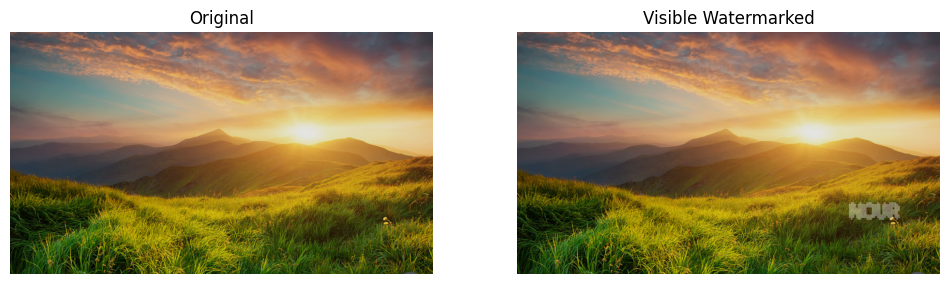

In [5]:
# Cell B — Visible watermark embedding (overlay)
import numpy as np
import matplotlib.pyplot as plt

def embed_visible(orig_u8, wm_bits, pos="bottom-right", scale=3, alpha=0.35, color=(255,255,255), pad=20):
    """
    orig_u8: HxWx3 uint8 image
    wm_bits: hxw uint8 {0,1}
    scale: integer upscaling factor for watermark
    alpha: blending strength (0..1)
    color: watermark color (RGB)
    """
    img = orig_u8.copy()
    H, W, _ = img.shape

    # upscale watermark with nearest-neighbor (no blurring)
    wm = np.kron(wm_bits, np.ones((scale, scale), dtype=np.uint8))  # (h*scale, w*scale)
    h, w = wm.shape

    # choose position
    if pos == "bottom-right":
        y0 = H - h - pad
        x0 = W - w - pad
    elif pos == "bottom-left":
        y0 = H - h - pad
        x0 = pad
    elif pos == "top-right":
        y0 = pad
        x0 = W - w - pad
    elif pos == "top-left":
        y0 = pad
        x0 = pad
    else:
        raise ValueError("pos must be one of: bottom-right, bottom-left, top-right, top-left")

    # clamp if watermark too big
    y0 = max(0, min(y0, H - h))
    x0 = max(0, min(x0, W - w))

    roi = img[y0:y0+h, x0:x0+w].astype(np.float32)

    # build colored mask
    mask = wm.astype(np.float32)[..., None]  # h x w x 1
    wm_rgb = np.zeros_like(roi)
    wm_rgb[..., 0] = color[0]
    wm_rgb[..., 1] = color[1]
    wm_rgb[..., 2] = color[2]

    # alpha blend only where wm==1
    out = roi * (1 - alpha*mask) + wm_rgb * (alpha*mask)
    img[y0:y0+h, x0:x0+w] = np.clip(out, 0, 255).astype(np.uint8)

    return img

watermarked_visible = embed_visible(orig_u8, wm_bits, pos="bottom-right", scale=4, alpha=0.35)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(orig_u8); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(watermarked_visible); plt.title("Visible Watermarked"); plt.axis("off")
plt.show()


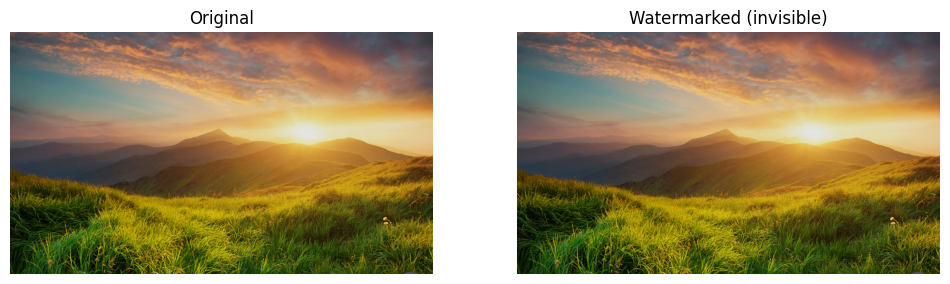

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def embed_lsb_region(orig_u8, wm_bits, top_left=(20,20), channel=2):
    img = orig_u8.copy()
    H, W, _ = img.shape
    h, w = wm_bits.shape
    y0, x0 = top_left
    if y0 + h > H or x0 + w > W:
        raise ValueError("Watermark doesn't fit at that position. Change top_left or reduce watermark size.")
    region = img[y0:y0+h, x0:x0+w, channel]
    img[y0:y0+h, x0:x0+w, channel] = (region & 254) | (wm_bits.astype(np.uint8) & 1)
    return img

# Embed your watermark bits into the image
wm_img = embed_lsb_region(orig_u8, wm_bits, top_left=(20,20), channel=2)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(orig_u8); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(wm_img); plt.title("Watermarked (invisible)"); plt.axis("off")
plt.show()


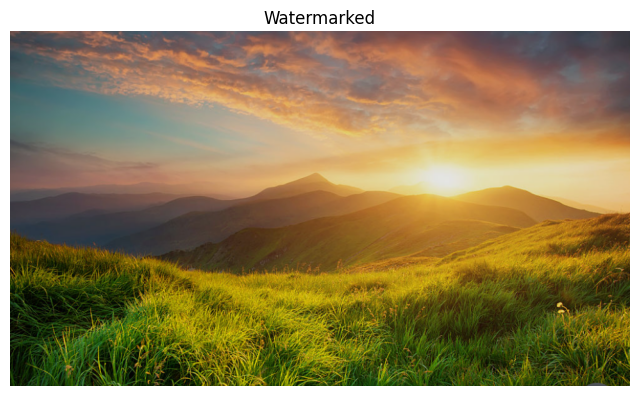

In [7]:
import time
from IPython.display import display, clear_output

def toggle_images(imgA, imgB, cycles=12, delay=0.25, titles=("Original", "Watermarked")):
    for i in range(cycles):
        clear_output(wait=True)
        plt.figure(figsize=(8,5))
        if i % 2 == 0:
            plt.imshow(imgA); plt.title(titles[0])
        else:
            plt.imshow(imgB); plt.title(titles[1])
        plt.axis("off")
        plt.show()
        time.sleep(delay)

toggle_images(orig_u8, wm_img, cycles=14, delay=0.22)


orig_u8 dtype/shape: uint8 (553, 967, 3)
wm_img  dtype/shape: uint8 (553, 967, 3)
Max abs diff (should be 1 for pure LSB): 1
Nonzero count: 2132
Nonzero fraction: 0.0013289674384277294


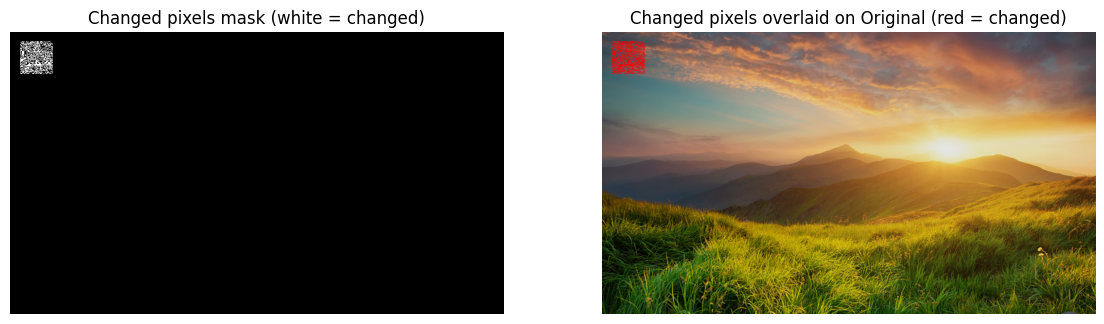

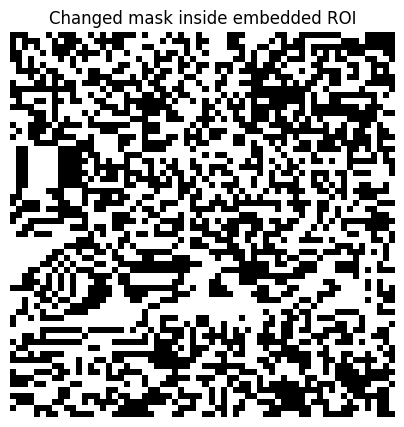

Changed pixels inside ROI: 2132 out of 4096


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) HARD sanity checks: did anything change at all? ---
diff_i16 = wm_img.astype(np.int16) - orig_u8.astype(np.int16)
absdiff = np.abs(diff_i16)

print("orig_u8 dtype/shape:", orig_u8.dtype, orig_u8.shape)
print("wm_img  dtype/shape:", wm_img.dtype, wm_img.shape)

print("Max abs diff (should be 1 for pure LSB):", absdiff.max())
print("Nonzero count:", np.count_nonzero(absdiff))
print("Nonzero fraction:", np.count_nonzero(absdiff) / absdiff.size)

# If this prints max=0 and nonzero=0, embedding did NOT happen (or you're comparing wrong arrays).

# --- 2) SHOW WHERE pixels changed (mask overlay) ---
# This will NOT be black unless literally nothing changed.
changed_mask = (absdiff.sum(axis=2) > 0).astype(np.uint8)  # HxW mask of changed pixels

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(changed_mask, cmap="gray")
plt.title("Changed pixels mask (white = changed)")
plt.axis("off")

# Overlay mask in red on top of original for clarity
overlay = orig_u8.copy()
overlay[changed_mask == 1] = [255, 0, 0]  # mark changed pixels red

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title("Changed pixels overlaid on Original (red = changed)")
plt.axis("off")
plt.show()

# --- 3) ROI check (to confirm you're looking at the embedded area) ---
y0, x0 = (20, 20)          # MUST match your embed top_left
h, w = wm_bits.shape

roi_mask = changed_mask[y0:y0+h, x0:x0+w]
plt.figure(figsize=(5,5))
plt.imshow(roi_mask, cmap="gray")
plt.title("Changed mask inside embedded ROI")
plt.axis("off")
plt.show()

print("Changed pixels inside ROI:", roi_mask.sum(), "out of", roi_mask.size)



In [9]:
def psnr(a, b):
    a = a.astype(np.float32); b = b.astype(np.float32)
    mse = np.mean((a - b) ** 2)
    if mse == 0:
        return float("inf")
    return 20 * np.log10(255.0 / np.sqrt(mse))

print("PSNR (dB):", psnr(orig_u8, wm_img))


PSNR (dB): 76.89566


In [10]:
import sys
print(sys.executable)



C:\Users\User\AppData\Local\Programs\Python\Python313\python.exe


In [11]:
from PIL import Image
import io
import numpy as np

def jpeg_attack(image, quality=25):
    pil_img = Image.fromarray(image)
    buffer = io.BytesIO()
    pil_img.save(buffer, format="JPEG", quality=quality)
    buffer.seek(0)
    return np.array(Image.open(buffer))



In [12]:
jpeg_img = jpeg_attack(wm_img, quality=25)


In [13]:
print(wm_img.shape)


(553, 967, 3)


In [14]:
# Extract LSB watermark bits from a given image
def extract_lsb_region(image, top_left=(20, 20), wm_shape=(64, 64), channel=2):
    y0, x0 = top_left
    h, w = wm_shape
    region = image[y0:y0+h, x0:x0+w, channel]
    return region & 1


In [15]:
# Compute Bit Error Rate (BER)
def compute_ber(original_bits, extracted_bits):
    total_bits = original_bits.size
    bit_errors = np.sum(original_bits != extracted_bits)
    return bit_errors / total_bits


In [16]:
#JPEG ATTACK (Simulates real-world image compression) 
from PIL import Image
import io
import numpy as np

def jpeg_attack(image, quality=25):
    pil_img = Image.fromarray(image)
    buffer = io.BytesIO()
    pil_img.save(buffer, format="JPEG", quality=quality)
    buffer.seek(0)
    return np.array(Image.open(buffer))
    
jpeg_img = jpeg_attack(wm_img, quality=25)

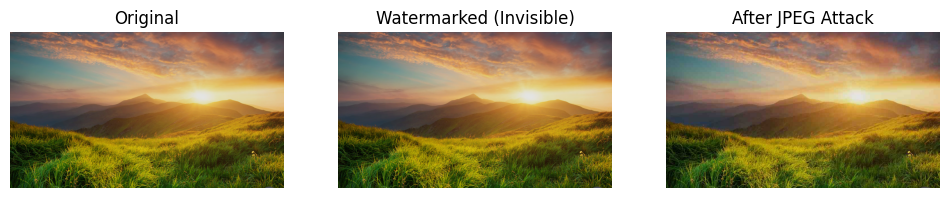

In [17]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(orig_u8)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(wm_img)
plt.title("Watermarked (Invisible)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(jpeg_img)
plt.title("After JPEG Attack")
plt.axis("off")

plt.show()


In [18]:
print("PSNR after JPEG attack (dB):", psnr(wm_img, jpeg_img))


PSNR after JPEG attack (dB): 28.568861


In [19]:
# BER after JPEG attack
jpeg_bits = extract_lsb_region(
    jpeg_img,
    top_left=(20, 20),
    wm_shape=wm_bits.shape,
    channel=2
)

ber_jpeg = compute_ber(wm_bits, jpeg_bits)
print("BER after JPEG attack:", ber_jpeg)


BER after JPEG attack: 0.561767578125


In [20]:
# Gaussian Noise Attack (Adds random noise to the image)
def noise_attack(image, mean=0, var=5):
    noise = np.random.normal(mean, var, image.shape)
    noisy = image.astype(np.float32) + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

noise_img = noise_attack(wm_img)



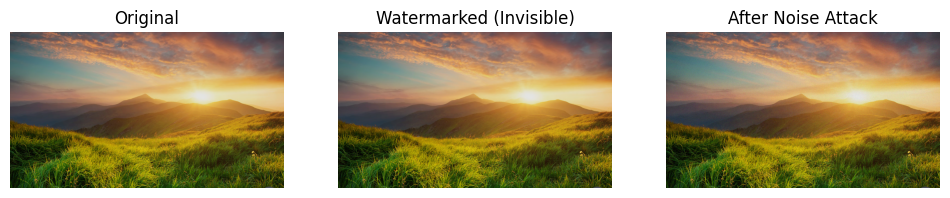

In [21]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(orig_u8)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(wm_img)
plt.title("Watermarked (Invisible)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(noise_img)
plt.title("After Noise Attack")
plt.axis("off")

plt.show()


In [22]:
print("PSNR after Noise attack (dB):", psnr(wm_img, noise_img))


PSNR after Noise attack (dB): 34.20381


In [23]:
# BER after Gaussian Noise attack
noise_bits = extract_lsb_region(
    noise_img,
    top_left=(20, 20),
    wm_shape=wm_bits.shape,
    channel=2
)

ber_noise = compute_ber(wm_bits, noise_bits)
print("BER after Gaussian Noise attack:", ber_noise)


BER after Gaussian Noise attack: 0.50048828125


In [24]:
# Cropping Attack (Removes part of the image, which may remove the embedded watermark region)
def crop_attack(image, crop_ratio=0.2):
    h, w, _ = image.shape
    ch, cw = int(h * crop_ratio), int(w * crop_ratio)
    return image[ch:h-ch, cw:w-cw]

crop_img = crop_attack(wm_img)


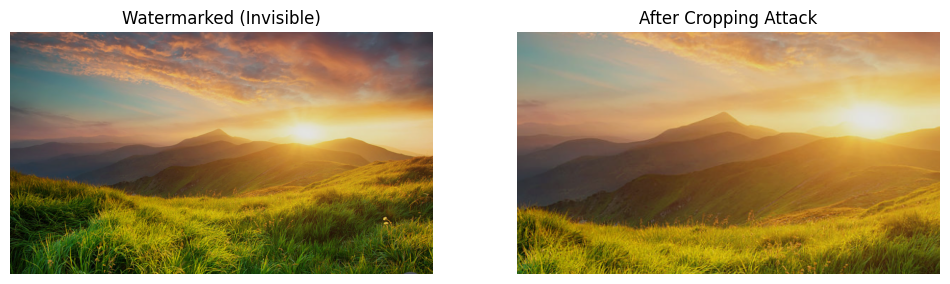

In [25]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(wm_img)
plt.title("Watermarked (Invisible)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(crop_img)
plt.title("After Cropping Attack")
plt.axis("off")

plt.show()


In [26]:
# BER after Cropping attack

# Extract watermark bits from cropped image
crop_bits = extract_lsb_region(
    crop_img,
    top_left=(20, 20),   # same position used during embedding
    wm_shape=wm_bits.shape,
    channel=2            # Blue channel (LSB)
)

ber_crop = compute_ber(wm_bits, crop_bits)

print("BER after Cropping attack:", ber_crop)


BER after Cropping attack: 0.525146484375


In [27]:
# Resizing Attack (Simulates scaling operations that distort pixel alignment) 
def resize_attack(image, scale=0.5):
    pil_img = Image.fromarray(image)
    w, h = pil_img.size
    resized = pil_img.resize((int(w*scale), int(h*scale)))
    resized_back = resized.resize((w, h))
    return np.array(resized_back)

resize_img = resize_attack(wm_img, scale=0.5)


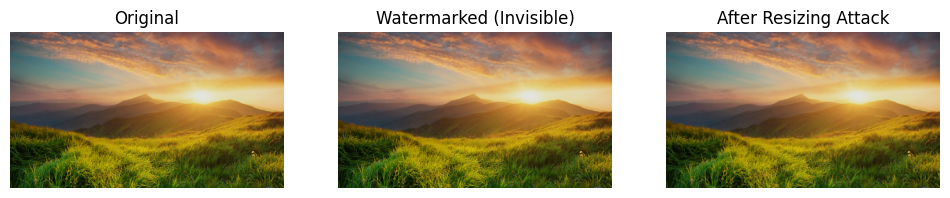

In [28]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(orig_u8)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(wm_img)
plt.title("Watermarked (Invisible)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(resize_img)
plt.title("After Resizing Attack")
plt.axis("off")

plt.show()


In [29]:
print("PSNR after Resizing attack (dB):", psnr(wm_img, resize_img))


PSNR after Resizing attack (dB): 30.176987


In [30]:
# BER after Resizing attack (FIXED)
resize_bits = extract_lsb_region(
    resize_img,
    top_left=(20, 20),
    wm_shape=wm_bits.shape,
    channel=2
)

ber_resize = compute_ber(wm_bits, resize_bits)
print("BER after Resizing attack:", ber_resize)


BER after Resizing attack: 0.451904296875
